# Importing necessary libraries

useful links I followed:
- https://towardsdatascience.com/clustering-product-names-with-python-part-1-f9418f8705c8
- https://towardsdatascience.com/clustering-product-names-with-python-part-2-648cc54ca2ac
- https://stackoverflow.com/questions/56840573/python-sklearn-how-to-get-clusters-and-cluster-names-after-doing-kmeans
- https://machinelearningmastery.ru/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a/

In [5]:
# following to "Clustering product names" note:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px

#Libraries for preprocessing
from gensim.parsing.preprocessing import remove_stopwords # useful but not for cernogorian language, alas
import string
from nltk.stem import PorterStemmer # the same, m.b. improve later
from nltk.tokenize import word_tokenize
import webcolors

#Download once if using NLTK for preprocessing
import nltk
#nltk.download('popular') # this needs to run only once to download various tokenizers etc

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from fuzzywuzzy import fuzz

#Libraries for clustering
from sklearn.cluster import KMeans

# following to "ML NLP text classification..." note:

# automatic subdivision dataset to train/test data with changing parts
from sklearn.model_selection import cross_val_score
# Naive Bayes classifyer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, CategoricalNB
# SGD Classifier
from sklearn.linear_model import SGDClassifier

# Data preparation and understanding

In [6]:
df = pd.read_csv('data.csv', header=None, usecols=[1,2])
df.rename(columns={1:'description',2:'category'}, inplace=True)
df.columns

Index(['description', 'category'], dtype='object')

In [7]:
df.shape

(574, 2)

In [8]:
df

,description,category
0,Suva Svinjska Pecenica Matijevic Slajs 100G,semi-finished products
1,Panceta Matijevic Slajs 150G,semi-finished products
2,Pršuta Slajs Martex 100G,semi-finished products
3,Suvi Vrat Martex 100G,semi-finished products
4,Sunka Pik Vrbovec Fina 150G,semi-finished products
...,...,...
569,Domaća oblanda 350g Slatko srce (142946),cakes and pastries
570,Vanilice 450g Slatko srce (142949),cakes and pastries
571,Ruske kape 450g Slatko srce (146073),cakes and pastries
572,Francuski makaronsi 24 kom 288g Chateau Blanc ...,cakes and pastries


## How many products in categories we have

<BarContainer object of 17 artists>

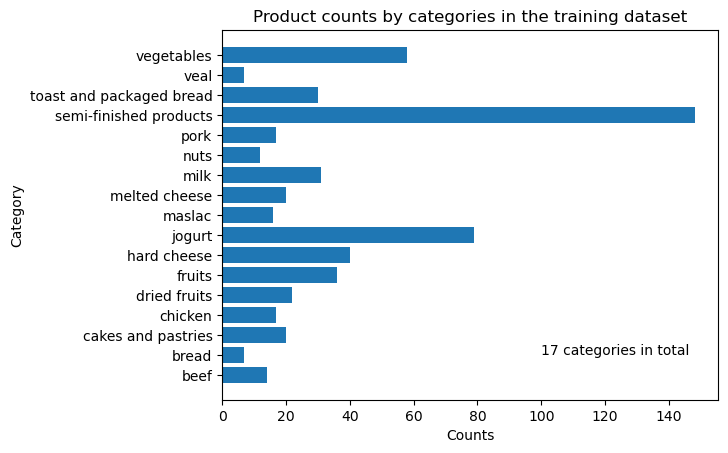

In [10]:
# let's look how much elements of various categories we have
cat_counts = df.groupby(['category'], as_index=False).count().rename(columns={'description':'count'})
fig_categ_stats, ax_cs = plt.subplots(figsize=(6.4,4.8))
ax_cs.set_xlabel('Counts')
ax_cs.set_ylabel('Category')
ax_cs.set_title('Product counts by categories in the training dataset')
ax_cs.text(100, 1, str(df.category.nunique())+' categories in total')
ax_cs.barh(cat_counts['category'], cat_counts['count'])

## Preprocessing (removing unnecessary symbols and words)

In [12]:
# lower case
text1 = df.description.apply(lambda x: x.lower())
# remove stopwords, punctuation and numbers
text2 = [remove_stopwords(x)\
        .translate(str.maketrans('','',string.punctuation))\
        .translate(str.maketrans('','',string.digits))\
        for x in text1]

In [13]:
# in the original note then goes stemming, but currently I see no signs that we need it here, maybe it will change later
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

# useless for cernogorian language until we have some dictionary

In [14]:
# let's see what is still necessary to remove
df_semiprocessed = pd.DataFrame(pd.concat([pd.Series(text1), pd.Series(text2)], axis=1))
df_semiprocessed.rename(columns={0: 'desc_nonum'}, inplace=True)
df_semiprocessed
# we see that all non-alphabetical symbols were removed
# but there are still units (g, kg, l etc) present in the product name string after this processing

,description,desc_nonum
0,suva svinjska pecenica matijevic slajs 100g,suva svinjska pecenica matijevic slajs g
1,panceta matijevic slajs 150g,panceta matijevic slajs g
2,pršuta slajs martex 100g,pršuta slajs martex g
3,suvi vrat martex 100g,suvi vrat martex g
4,sunka pik vrbovec fina 150g,sunka pik vrbovec fina g
...,...,...
569,domaća oblanda 350g slatko srce (142946),domaća oblanda g slatko srce
570,vanilice 450g slatko srce (142949),vanilice g slatko srce
571,ruske kape 450g slatko srce (146073),ruske kape g slatko srce
572,francuski makaronsi 24 kom 288g chateau blanc ...,francuski makaronsi kom g chateau blanc


## Make list of words which are not helpful for classifying

1) names of colors might be present in various products from various categories and must be deleted. The trouble is that we work with text in cernogorian language. I added the colors manually to the list, looking through the dataset.

2) Unit names also bring no information on the product category, in addition there are some partial cases where the unit name is glued to some rangom symbol after removing the numbers (e.g. 'x100gr' becomes 'xgr').

3) Auxiliary words (like prepositions) are also not necessary for us. Manually fount two of them ('sa', 'za').

In [15]:
# removing colors might be helpful, but in current data...
# they ALL ARE IN CHERNOGORIAN (wchich is not Serbian but somewhere close enough)
# quick manual analysis:
# ['bijeli', 'bijela', 'bijelo', 'crni', 'crna', 'crno', 'crveni', 'crvena', 'crveno', 'zlatni', 'zeleni', 'zelena', 'žuti', 'žuta']

# list of stop words for vectorizer
# colors in Chernogorian
sw_cernogor = ['bijeli', 'bijela', 'bijelo', 
                       'crni', 'crna', 'crno', 
                       'crveni', 'crvena', 'crveno', 
                       'zlatni', 'zeleni', 'zelena', 
                       'žuti', 'žuta', 'white'] # yes there are two names with 'white'!!!
# units (i hope they are quite international otherwise we need to top up this list)
sw_units = ['kg', 'g', 'gr', 'ml', 'l', 'cl', 'mm', 'mmg', 'xgr']
sw_aux_words = ['sa', 'za']

### This is service cell for searching some certain products having something I'm interested in

In [16]:
# service cell for investigation of the data
#df[df.description.apply(lambda x: ('4g' in x) or ('5g' in x) or ('0g' in x))]
df[df_semiprocessed.desc_nonum.apply(lambda x: 'xgr' in x)]
#df[(df.category=='vegetables')|(df.category=='fruits')].head(100)
#df[df.category=='dried fruits']

,description,category
326,Jogurt voćni Campina fruttis mijesano voće 4x1...,jogurt


## Removing the stopwords

In [17]:
text3 = [remove_stopwords(x, stopwords=sw_cernogor+sw_units+sw_aux_words) for x in text2]
df['description_upd'] = pd.Series(text3)

df

,description,category,description_upd
0,Suva Svinjska Pecenica Matijevic Slajs 100G,semi-finished products,suva svinjska pecenica matijevic slajs
1,Panceta Matijevic Slajs 150G,semi-finished products,panceta matijevic slajs
2,Pršuta Slajs Martex 100G,semi-finished products,pršuta slajs martex
3,Suvi Vrat Martex 100G,semi-finished products,suvi vrat martex
4,Sunka Pik Vrbovec Fina 150G,semi-finished products,sunka pik vrbovec fina
...,...,...,...
569,Domaća oblanda 350g Slatko srce (142946),cakes and pastries,domaća oblanda slatko srce
570,Vanilice 450g Slatko srce (142949),cakes and pastries,vanilice slatko srce
571,Ruske kape 450g Slatko srce (146073),cakes and pastries,ruske kape slatko srce
572,Francuski makaronsi 24 kom 288g Chateau Blanc ...,cakes and pastries,francuski makaronsi kom chateau blanc


# Making the proper dataset for our classifiers

Here we start with vectorization of our product names. Vectorizer finds the unique words (or sometimes word combinations) and  gets a list of these words (can be seen via vectorizer.get_feature_names_out()). Then it represents each product name as a vector of numbers. The i-th element of vector is zero if i-th word in feature_names_out is not found in the product name. The i-th element is not zero if i-th words IS in the product name. The non-zero value might be 1 for CountVectorizer or some float value for TF-IDF vectorizer which counts not only word presence in the string, but also the value connected with the frequency of the specified word.

In [18]:
# this is the target vector for out ML magic
Y_tot = df.category

In [19]:
vector_cv = CountVectorizer(
                            #token_pattern=r'[a-z]+', 
                            analyzer='word', 
                            strip_accents='unicode'
                            # min_df = 2, max_df = 8,
                            #stop_words = sw_cernogor+sw_units
                            ) # created the vectorizer
X_tot_cv = vector_cv.fit_transform(df.description_upd) # making word vectors out of our product rectified names

word_token_list = vector_cv.get_feature_names_out()
print('Total feature count is', len(word_token_list))
print([name for name in word_token_list])
type(word_token_list)
# from here we see that stemming still necessary, but in cernogorian language!
# currently just work as is, deal with it later

Total feature count is 567
['abata', 'abc', 'aia', 'ajdara', 'ajdared', 'ala', 'alpska', 'ambrosi', 'ananas', 'argeta', 'aroma', 'avokado', 'babura', 'baby', 'badem', 'badembrusnica', 'baget', 'bajadera', 'balans', 'balansobrok', 'banana', 'barena', 'barilla', 'base', 'basta', 'bastensko', 'batak', 'batat', 'bauletto', 'bayernland', 'baza', 'belje', 'berny', 'bez', 'bianco', 'bilje', 'biscott', 'biser', 'blanc', 'blitva', 'bonesa', 'brasnom', 'breskvice', 'brisaola', 'brokoli', 'brokula', 'brusnica', 'budimska', 'bugarske', 'buterom', 'butkice', 'butter', 'cabata', 'cacao', 'cajna', 'campina', 'carnex', 'carre', 'carrefioco', 'carska', 'casa', 'casica', 'cekin', 'celer', 'cepa', 'cepom', 'cevapi', 'chateau', 'cheddar', 'cimet', 'classic', 'classico', 'cokolada', 'cokoladni', 'company', 'conad', 'crnogorska', 'cuor', 'cupavci', 'cureca', 'curece', 'cureci', 'cvekla', 'daily', 'dairy', 'dalmatinski', 'delikates', 'delises', 'deluxe', 'di', 'diet', 'dijamant', 'dijet', 'dijetalni', 'dimlj

numpy.ndarray

In [20]:
matrix_cv = pd.concat([pd.Series(text1), pd.DataFrame(X_tot_cv.toarray(), columns=vector_cv.get_feature_names_out())], axis=1)\
         .rename(columns={'description':'name'})

#matrix_cv.columns
matrix_cv[['name','suva','svinjska', 'vrat', 'vrbovec', 'martex', 'pik']].head(10)

,name,suva,svinjska,vrat,vrbovec,martex,pik
0,suva svinjska pecenica matijevic slajs 100g,1,1,0,0,0,0
1,panceta matijevic slajs 150g,0,0,0,0,0,0
2,pršuta slajs martex 100g,0,0,0,0,1,0
3,suvi vrat martex 100g,0,0,1,0,1,0
4,sunka pik vrbovec fina 150g,0,0,0,1,0,1
5,zimska salama pik vrbovec 100g,0,0,0,1,0,1
6,prsut majstor mesar lovcenski slajs 100g,0,0,0,0,0,0
7,prsut pik vrbovec dalmatinski 100g,0,0,0,1,0,1
8,cajna kobasica matijevic slajs 100g,0,0,0,0,0,0
9,cajna kobasica goranovic slajs 100g,0,0,0,0,0,0


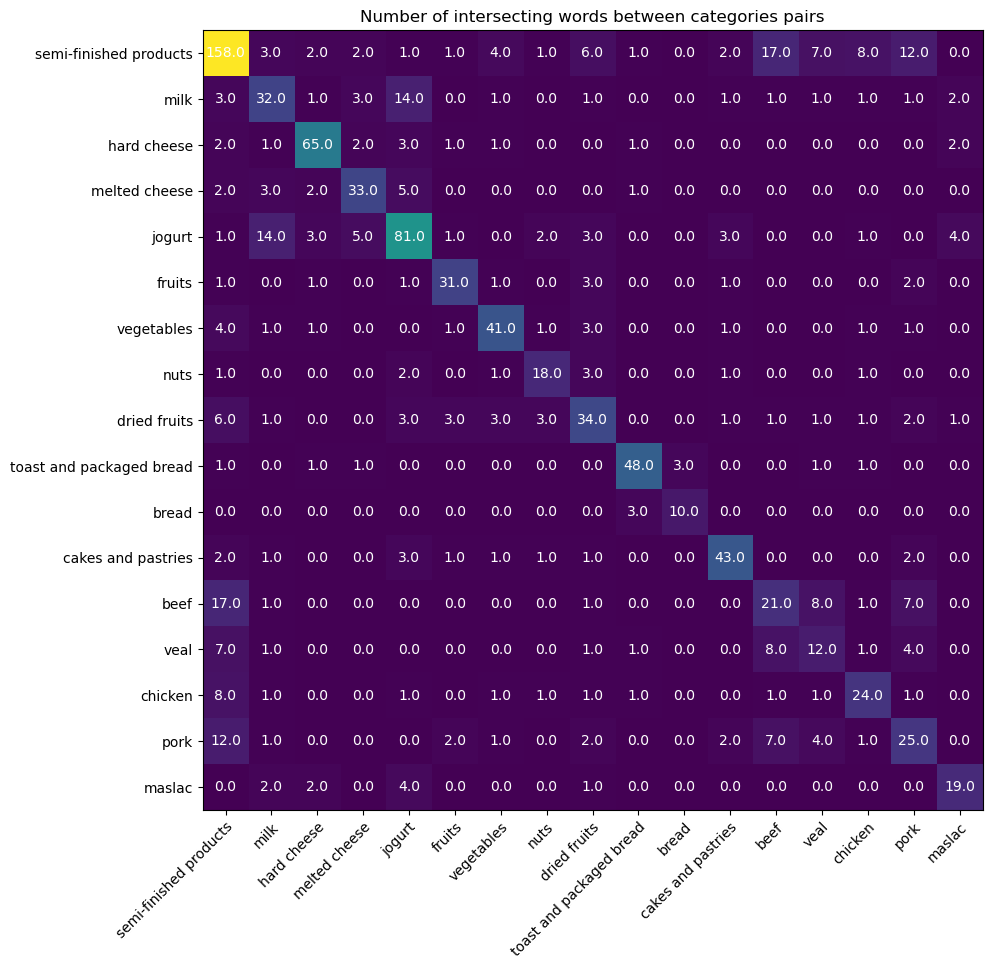

In [43]:
cv_part = CountVectorizer(
                          #token_pattern=r'[a-z]+', 
                          analyzer='word', 
                          strip_accents='unicode'
                          # min_df = 2, max_df = 8,
                          #stop_words = sw_cernogor+sw_units
                          ) # created the vectorizer

categs = df.category.unique()

catwords = []
n_products = []
n_words = []

for cat in categs:
    df_tmp = df[df.category == cat]
    # print(df_tmp.category.nunique(), df_tmp.iloc[0])
    X_tmp = cv_part.fit_transform(df_tmp.description_upd)
    catwords.append(set(cv_part.get_feature_names_out()))
    n_products.append(df_tmp.shape[0])
    n_words.append(len(cv_part.get_feature_names_out()))
    
common_word = np.empty((len(categs), len(categs)))



for i in range(len(categs)):
    for j in range(len(categs)):
        common_word[i, j] = len(catwords[i]&catwords[j])

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(common_word)
ax.set_xticks(np.arange(len(categs)), labels=categs)
ax.set_yticks(np.arange(len(categs)), labels=categs)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(len(categs)):
    for j in range(len(categs)):
        text = ax.text(j, i, common_word[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Number of intersecting words between categories pairs")
fig.tight_layout()
plt.show()

In [51]:
# another vectorization also counts word frequencies in comparison to other words to assign it a weighted score of importance
vector_idf = TfidfVectorizer(analyzer='word', strip_accents='unicode')
X_tot_idf = vector_idf.fit_transform(df.description_upd)
matrix_idf = pd.concat([pd.Series(text3), pd.DataFrame(X_tot_idf.toarray(), columns=vector_idf.get_feature_names_out())], axis=1)\
         .rename(columns={0:'name'})

# check how it looks
matrix_idf[['name','suva','svinjska', 'vrat', 'vrbovec', 'martex', 'pik']].head(10)

,name,suva,svinjska,vrat,vrbovec,martex,pik
0,suva svinjska pecenica matijevic slajs,0.416975,0.446729,0.000000,0.000000,0.000000,0.000000
1,panceta matijevic slajs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,pršuta slajs martex,0.000000,0.000000,0.000000,0.000000,0.680280,0.000000
3,suvi vrat martex,0.000000,0.000000,0.529162,0.000000,0.641888,0.000000
4,sunka pik vrbovec fina,0.000000,0.000000,0.000000,0.471909,0.000000,0.462268
5,zimska salama pik vrbovec,0.000000,0.000000,0.000000,0.468724,0.000000,0.459148
6,prsut majstor mesar lovcenski slajs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,prsut pik vrbovec dalmatinski,0.000000,0.000000,0.000000,0.466889,0.000000,0.457350
8,cajna kobasica matijevic slajs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,cajna kobasica goranovic slajs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [53]:
# here we add not only single words, but also pairs of words
# ngram_range=(1, 2) might be optional, but we also can check if triple combinations of words
# give something new for classifying

vector_ntf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), strip_accents='unicode')
X_tot_ntf = vector_ntf.fit_transform(df.description_upd)
matrix_ntf = pd.concat([pd.Series(text3), pd.DataFrame(X_tot_ntf.toarray(), columns=vector_ntf.get_feature_names_out())], axis=1)\
         .rename(columns={0:'name'})

matrix_ntf[['name','suva','svinjska', 'vrat', 'vrbovec', 'martex', 'pik', 'suva svinjska']].head(10)

,name,suva,svinjska,vrat,vrbovec,martex,pik,suva svinjska
0,suva svinjska pecenica matijevic slajs,0.28179,0.301898,0.000000,0.000000,0.000000,0.000000,0.356656
1,panceta matijevic slajs,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,pršuta slajs martex,0.00000,0.000000,0.000000,0.000000,0.475194,0.000000,0.000000
3,suvi vrat martex,0.00000,0.000000,0.386015,0.000000,0.468247,0.000000,0.000000
4,sunka pik vrbovec fina,0.00000,0.000000,0.000000,0.343038,0.000000,0.336030,0.000000
5,zimska salama pik vrbovec,0.00000,0.000000,0.000000,0.339199,0.000000,0.332270,0.000000
6,prsut majstor mesar lovcenski slajs,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,prsut pik vrbovec dalmatinski,0.00000,0.000000,0.000000,0.334746,0.000000,0.327907,0.000000
8,cajna kobasica matijevic slajs,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,cajna kobasica goranovic slajs,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [58]:
# feature names for vectorizer countint up to pairs of words
print('Total feature count is', len(vector_ntf.get_feature_names_out()))
print([name for name in vector_ntf.get_feature_names_out()])

Total feature count is 1438
['abata', 'abc', 'abc belje', 'abc krem', 'aia', 'aia gran', 'aia wudy', 'ajdara', 'ajdara poljska', 'ajdared', 'ala', 'ala kajmak', 'alpska', 'alpska kobasica', 'ambrosi', 'ananas', 'argeta', 'argeta junior', 'argeta kokosija', 'aroma', 'avokado', 'avokado komad', 'babura', 'baby', 'baby rotkvica', 'badem', 'badem rinfiuz', 'badembrusnica', 'badembrusnica grozdje', 'baget', 'baget aroma', 'baget tamni', 'bajadera', 'bajadera slatko', 'balans', 'balans fermentisani', 'balans imlek', 'balans imuno', 'balans pet', 'balansobrok', 'balansobrok jagod', 'banana', 'banana klasa', 'banana svjeza', 'banana zbregov', 'barena', 'barena pileca', 'barilla', 'barilla dvopek', 'barilla hljeb', 'barilla tost', 'base', 'basta', 'basta blitva', 'basta krastavac', 'basta kristalka', 'basta tikvica', 'bastensko', 'bastensko bilje', 'batak', 'batak dimljeni', 'batak karabatkom', 'batak svjeze', 'batak svjezi', 'batak zabatak', 'batat', 'batat slatki', 'bauletto', 'bauletto bianc

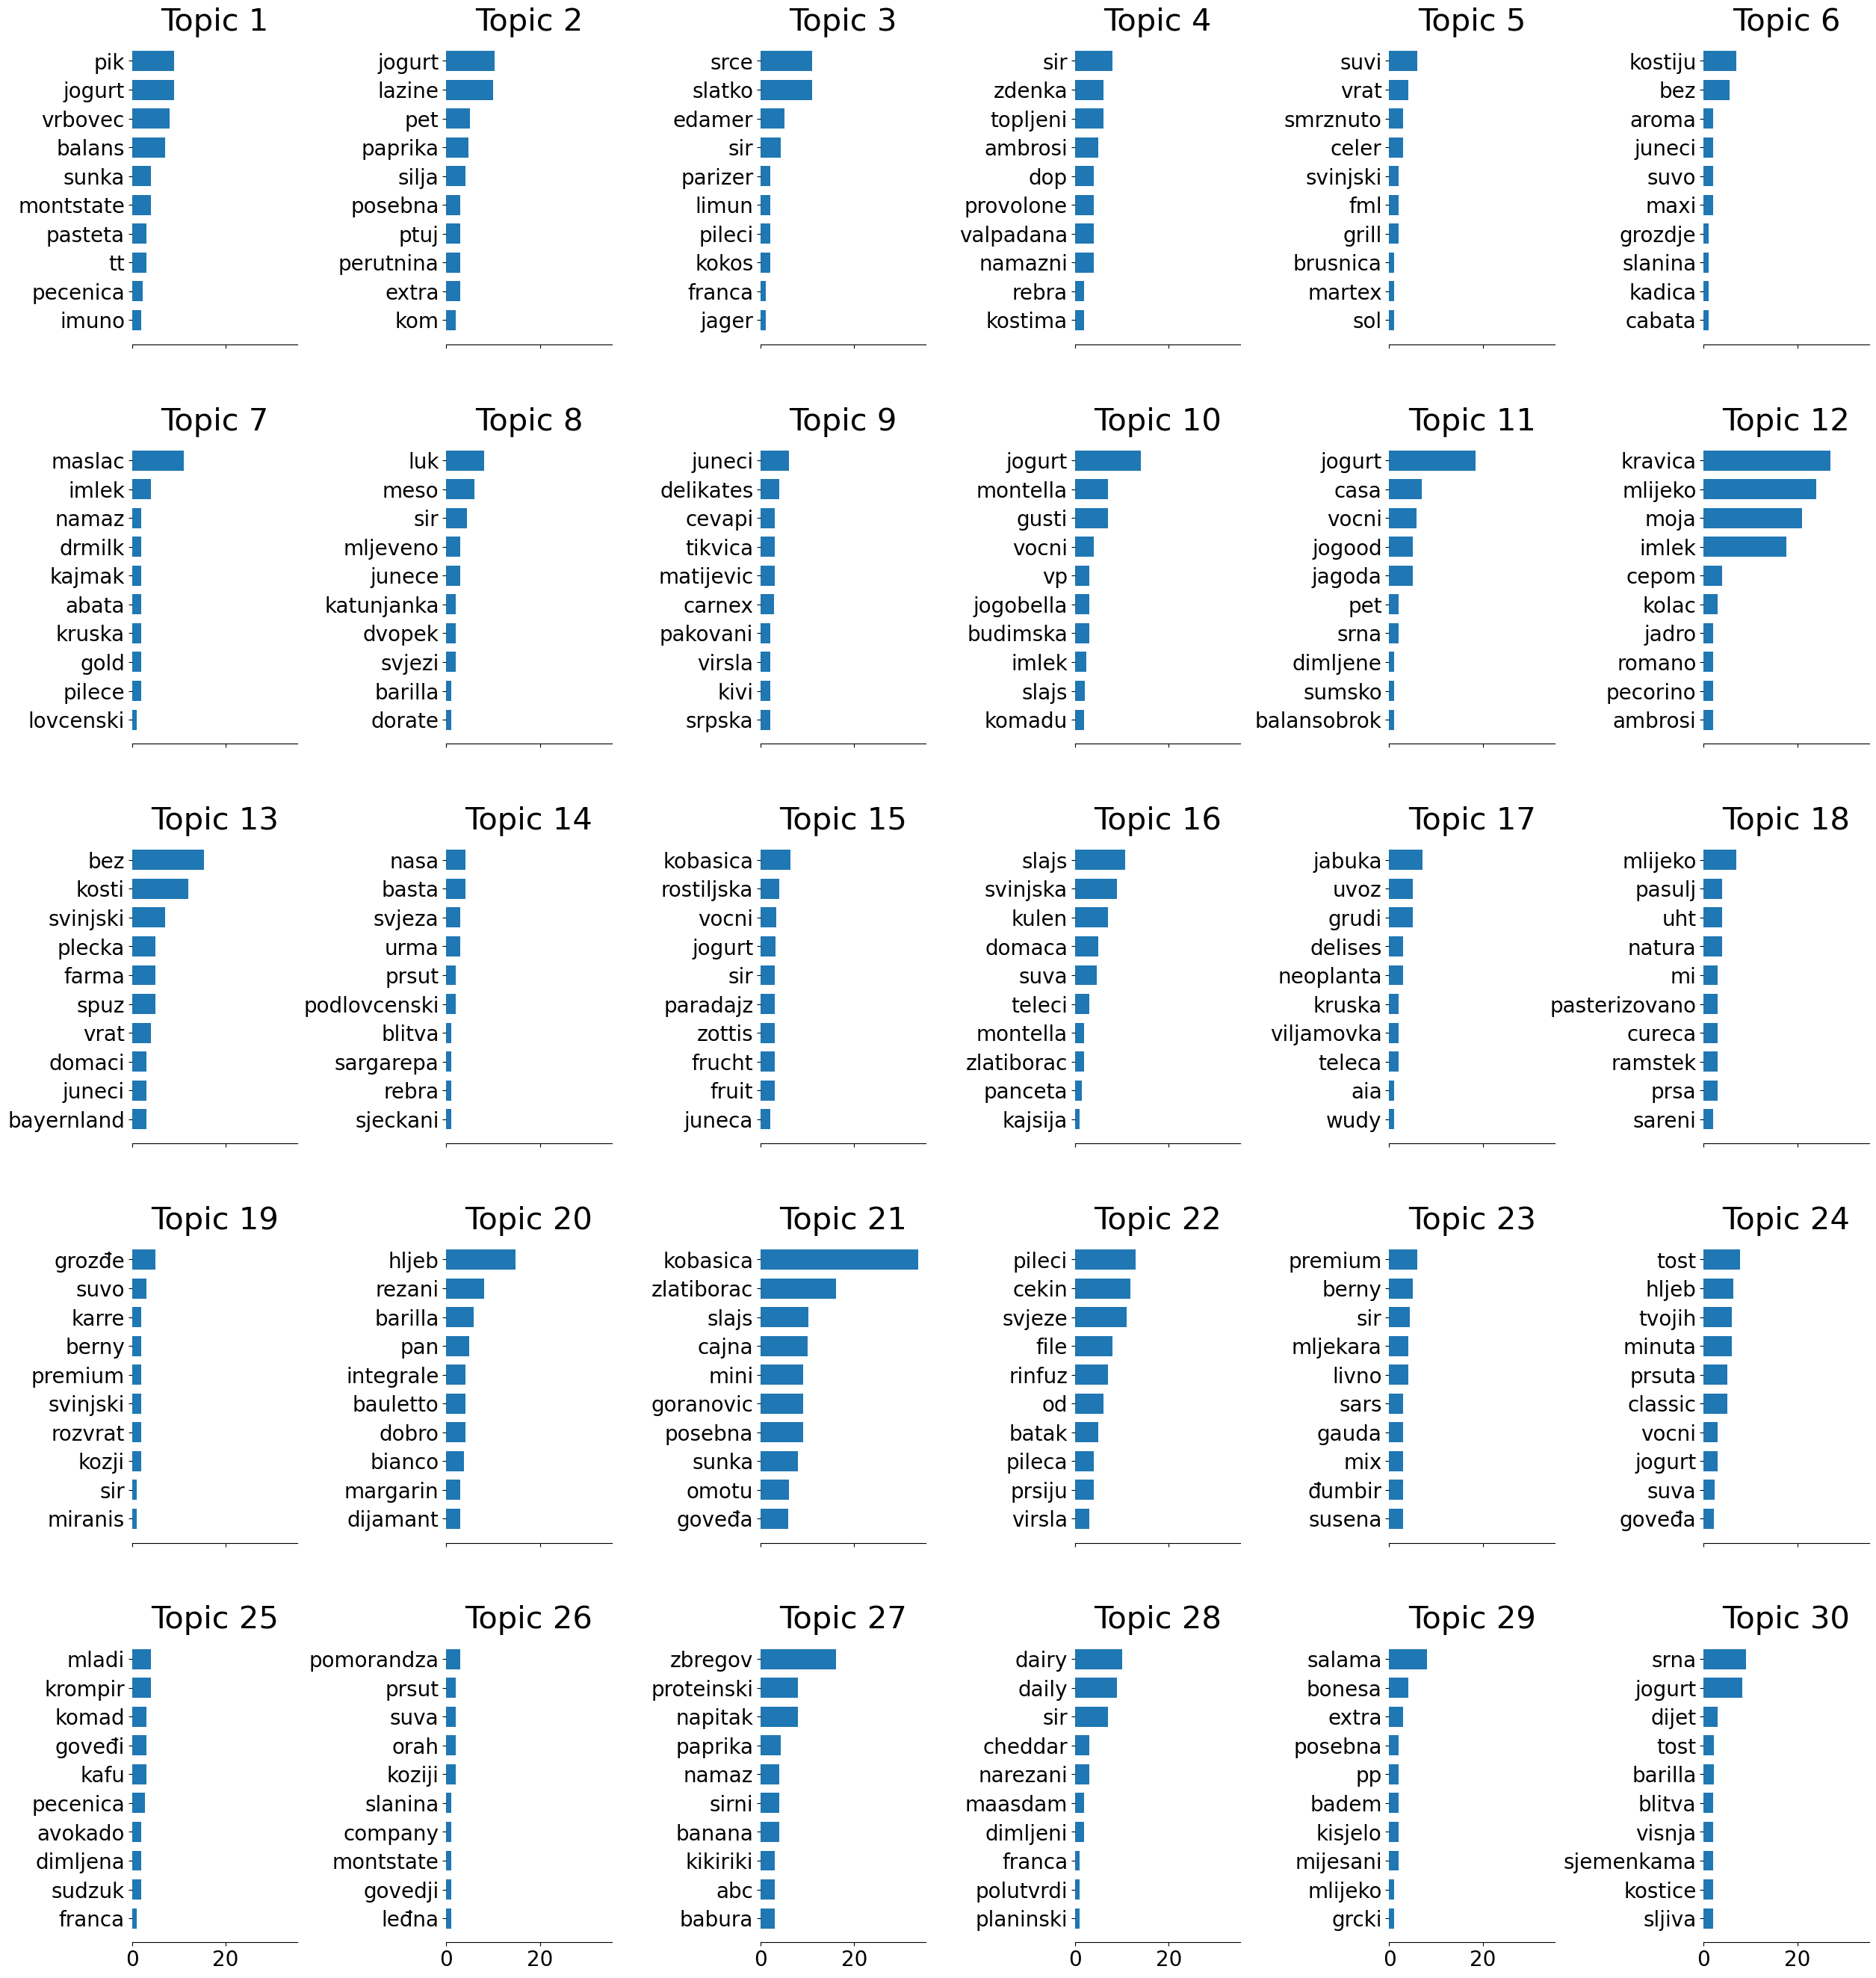

In [46]:
# although we have category names, here is LDA aka Latent Dirichlet Allocation
# "LDA can be very useful for large documents, such as news articles, 
# in uncovering its high level themes. However, it wasn’t quite right for 
# this data set as each food name isn’t necessarily made up of multiple topics."
# in the article on clustering products the number of 'topics' was found to be 30 and 5 words/topic
# in our case this looks as both values should be LESS (not more than 20 topics, manual categories are 17)

#LDA

n_topics = 30
n_top_words = 10

lda = LatentDirichletAllocation(n_components=n_topics, learning_decay=0.99)
X_lda = lda.fit(X_tot_cv)

#Plot topics function. Code from: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(5, 6, figsize=(30, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
#Show topics

feature_names = vector_cv.get_feature_names_out()
plot_top_words(X_lda, feature_names, n_top_words, '')

# well, I'm not sure how to use it in this form, maybe it will be useful later...

In [60]:
# Fuzzywuzzy
# With fuzzy library we can count how similar are different names
# Currently it's just for curiousity, I don't use it hereinafter.
text4 = pd.Series(text3)
X_fuzz = pd.crosstab([text4.index,text4],text4).apply(lambda col: [fuzz.token_sort_ratio(col.name, x) 
                                                                   for x in col.index.get_level_values(1)])
X_fuzz

,col_0,ananas,avokado komad,baby rotkvica,badem,badem rinfiuz,baget aroma s,baget tamni aroma s,bajadera slatko srce,balans imuno tt imlek,banana,...,ćureći file od prsiju pakovano smrznuto vindon,čajna kobasica,čupavci slatko srce,đumbir,đumbir suvi premium berny,šargarepa,šargarepa pakovana,škembići u paradajz sosu,štrudla trivit makom,šunka pileća pizza
row_0,row_1,,,,,,,,,,,,,,,,,,,,,
0,suva svinjska pecenica matijevic slajs,23,24,24,9,24,24,32,34,27,23,...,36,35,35,9,35,17,29,29,31,39
1,panceta matijevic slajs,34,28,33,14,22,44,43,47,27,28,...,29,38,33,14,25,25,34,26,47,34
2,pršuta slajs martex,32,25,31,17,31,38,37,46,25,24,...,25,30,32,16,32,36,27,28,46,32
3,suvi vrat martex,18,28,41,19,28,34,40,33,32,18,...,29,33,40,27,44,32,29,30,44,29
4,sunka pik vrbovec fina,29,29,34,15,23,29,24,33,37,29,...,38,28,39,14,38,26,35,26,29,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,domaća oblanda slatko srce,31,36,31,26,26,46,40,70,38,31,...,33,35,49,19,24,23,41,36,30,27
570,vanilice slatko srce,23,30,36,16,30,30,41,55,34,23,...,33,41,72,8,31,28,37,27,40,26
571,ruske kape slatko srce,21,29,34,15,29,40,34,71,33,14,...,35,28,54,14,34,32,35,30,29,30


In [64]:
print(X_fuzz.columns.shape)
print([col for col in X_fuzz.columns])

(517,)
['ananas', 'avokado komad', 'baby rotkvica', 'badem', 'badem rinfiuz', 'baget aroma s', 'baget tamni aroma s', 'bajadera slatko srce', 'balans imuno tt imlek', 'banana', 'banana klasa', 'banana svježa', 'barilla dvopek dorate', 'barilla dvopek integrale', 'barilla hljeb pan bauletto integrale', 'barilla tost pan carrefioco', 'batak dimljeni ćureći kostima', 'batat slatki krompir', 'blitva', 'bonesa perutninska', 'breskvice slatko srce', 'brokoli sveži', 'brokula', 'brusnica sars kadica', 'budimska kobasica', 'budimska montella', 'budimska slajs montella', 'bugarske ruže slatko srce', 'cabata maxi aroma s', 'cajna kobasica', 'cajna kobasica goranovic slajs', 'cajna kobasica matijevic slajs', 'cajna kobasica pik vrbovec slajs', 'cajna montella', 'celer', 'celer korjen', 'celer list', 'cheddar daily dairy', 'cheddar sir narezani daily dairy', 'cvekla', 'delikates juneći rozvrat', 'delišes', 'dimljena carska rebra', 'dimljena svinjska pecenica montstate', 'dimljene butkice', 'dimlje

In [70]:
print(X_tot_cv.shape) # just curious, what is the size of the result
print(X_tot_idf.shape) # just curious, what is the size of the result
print(X_tot_ntf.shape) # just curious, what is the size of the result
print(X_fuzz.shape)
# well, it's not clear why the number of word tokens is close to the number of product names, it shouldn't be so...

(574, 567)
(574, 567)
(574, 1438)
(574, 517)


In [71]:
# our processed bags of words are:
# X_tot_cv from vector_cv, X_tot_idf from vector_idf, X_tot_ntf from vector_ntf
# try to use Naive Bayes classifyer based on various count-vectorizers
myalpha = 1.e-3
clf_NB = MultinomialNB(alpha=myalpha) # created the classifyer
clf_SGD = SGDClassifier(loss='hinge', penalty='l2', alpha=myalpha, n_iter_no_change=5, random_state=42)
clf_B = BernoulliNB(alpha=myalpha)
clf_C = CategoricalNB(alpha=1.)

# cross_val_score(clf_NB, X_tot_cv, Y_tot, cv=5)
my_classifiers = {'NB': clf_NB, 'SGD': clf_SGD, 'Brn': clf_B}
my_vecs = {'CV': X_tot_cv, 'IDF': X_tot_idf, 'NTF': X_tot_ntf}
my_classifiers.keys()


dict_keys(['NB', 'SGD', 'Brn'])

In [73]:
cv_bins = 5

results =   []

for clf in my_classifiers.keys():
    res_0 = [clf]
    for vec in my_vecs.values():
        tmp_score = cross_val_score(my_classifiers[clf], vec, Y_tot, cv=cv_bins).mean()
        res_0.append(tmp_score)
    results.append(res_0)

print(results)
#cv_score = cross_val_score(clf_NB, X_tot_cv, Y_tot, cv=cv_bins).mean()
#idf_score = cross_val_score(clf_NB, X_tot_idf, Y_tot, cv=cv_bins).mean()
#ntf_score = cross_val_score(clf_NB, X_tot_ntf, Y_tot, cv=cv_bins).mean()
#print(cv_score, idf_score, ntf_score)

[['NB', 0.8308924485125859, 0.8413424866514111, 0.7803508771929824], ['SGD', 0.8709687261632342, 0.8762318840579711, 0.8604729214340198], ['Brn', 0.8431121281464531, 0.8431121281464531, 0.7838291380625476]]


It seems that: 

1) SGD Classifier is the best. 

2) Difference between CountVectorizer and TF-IDF is rather small

3) Vectorizing pairs of words is not effective

Now we need to extract it via pickle so that we could use it in an external function.

# Final model training and making output file

In [97]:
# X values for final training are arranged into a dataframe with column names
# in order to have these names when working with the pickled classifier
X_train_final = pd.DataFrame(X_tot_cv.toarray(), columns=vector_cv.get_feature_names_out())

clf_SGD.fit(X_train_final, Y_tot)

SGDClassifier(alpha=0.001, random_state=42)

I decided to fit the classifier using simple vectorizer (giving only 0 and 1 as features' values). The reason is that most probable scenario of using the classifier is applying it individually to a single string of product name scraped from anywhere. To apply the classifyer, we need to convert this string to a vector corresponding to the features list given by the CountVectorizer, and then use ***predict*** method

In [93]:
import pickle

clf_filename = 'SGD_clf.pickle'

with open(clf_filename, 'wb') as file:
    pickle.dump(clf_SGD, file)

Let's try to read the classifier from file

In [146]:
with open(clf_filename, 'rb') as f:
    clf_pickled = pickle.load(f)

In [99]:
clf_pickled

SGDClassifier(alpha=0.001, random_state=42)

In [101]:
# classes the classifier we loaded has
clf_pickled.classes_

array(['beef', 'bread', 'cakes and pastries', 'chicken', 'dried fruits',
       'fruits', 'hard cheese', 'jogurt', 'maslac', 'melted cheese',
       'milk', 'nuts', 'pork', 'semi-finished products',
       'toast and packaged bread', 'veal', 'vegetables'], dtype='<U24')

In [103]:
# features the classifier we loaded knows
clf_pickled.feature_names_in_

array(['abata', 'abc', 'aia', 'ajdara', 'ajdared', 'ala', 'alpska',
       'ambrosi', 'ananas', 'argeta', 'aroma', 'avokado', 'babura',
       'baby', 'badem', 'badembrusnica', 'baget', 'bajadera', 'balans',
       'balansobrok', 'banana', 'barena', 'barilla', 'base', 'basta',
       'bastensko', 'batak', 'batat', 'bauletto', 'bayernland', 'baza',
       'belje', 'berny', 'bez', 'bianco', 'bilje', 'biscott', 'biser',
       'blanc', 'blitva', 'bonesa', 'brasnom', 'breskvice', 'brisaola',
       'brokoli', 'brokula', 'brusnica', 'budimska', 'bugarske',
       'buterom', 'butkice', 'butter', 'cabata', 'cacao', 'cajna',
       'campina', 'carnex', 'carre', 'carrefioco', 'carska', 'casa',
       'casica', 'cekin', 'celer', 'cepa', 'cepom', 'cevapi', 'chateau',
       'cheddar', 'cimet', 'classic', 'classico', 'cokolada', 'cokoladni',
       'company', 'conad', 'crnogorska', 'cuor', 'cupavci', 'cureca',
       'curece', 'cureci', 'cvekla', 'daily', 'dairy', 'dalmatinski',
       'delikates'

In [140]:
test_name = 'suva slajs'

X0 = matrix_cv.sample(1).drop(['name'], axis=1)
X0
#clf_pickled.predict(X0)
X_test = [int(a in test_name.split()) for a in clf_pickled.feature_names_in_]
#X_test = np.array([clf_pickled.feature_names_in_, X_test]).reshape(-1, 1)
X_test = pd.DataFrame([X_test], columns = clf_pickled.feature_names_in_)

#clf_pickled.feature_names_in_.shape
clf_pickled.predict(X_test)

array(['semi-finished products'], dtype='<U24')

Now let's try to import the function I created

In [147]:
from peredelano_classifier_v0 import pp_classifier

pp_classifier(test_name)

TypeError: a bytes-like object is required, not 'str'